#**installing deps**

In [ ]:
# !pip install tensorflow
!pip install gym
!pip install oandapyV20
!pip install -U tapy
!pip install -q pyts
!pip install backtesting

     |████████████████████████████████| 51 kB 300 kB/s 
  Created wheel for oandapyV20: filename=oandapyV20-0.7.2-py3-none-any.whl size=70037 sha256=43fd5e3fe59528544b9a545ee9b70eb0cfdfdb6febc8fc90c3889701a98db64b
  Stored in directory: /root/.cache/pip/wheels/92/bd/c8/f003f96afcd47c2f94db568cf69d5834fd044897ced995babe
Successfully built oandapyV20
     |████████████████████████████████| 2.5 MB 5.5 MB/s 
     |████████████████████████████████| 174 kB 5.3 MB/s 
  Created wheel for backtesting: filename=Backtesting-0.3.2-py3-none-any.whl size=173671 sha256=ec16020a838c4f9ccc1d9a68b5b2c0edf5ac25933d547fcc5d6c6a14a6784fe3
  Stored in directory: /root/.cache/pip/wheels/22/0e/30/e458272563bdbea1905391b5bb5702e2001a769544d9cb2df3
Successfully built backtesting


In [ ]:
!pip install stable-baselines3[extra]
!pip install wandb

     |████████████████████████████████| 161 kB 5.5 MB/s 
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 139 kB 46.5 MB/s 
     |████████████████████████████████| 180 kB 41.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=73d41e29f0d36401f1b11f7a9118b1c7e3e8558ca19753a67e6055ecffb06d75
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=d6e5c5805002ca7c2c8ef19833befcf7ac0f1b892072b147884b0827af7338d1
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


#**imports**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# from pyts.image import GramianAngularField

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#**loading data**

In [ ]:
import pandas as pd
import oandapyV20.endpoints.instruments as instruments
import oandapyV20

In [ ]:
accountID = ""
access_token = ""

client = oandapyV20.API(access_token=access_token)

In [ ]:
def get_data(symbol, timeframe, count):
    params = {"count": count, "granularity": timeframe}
    r = instruments.InstrumentsCandles(instrument=symbol, params=params)
    client.request(r)
    candles = r.response['candles']

    df = pd.json_normalize(candles)
    df['High'] = df['mid.h'].astype('float64').dropna()
    df['Low'] = df['mid.l'].astype('float64').dropna()
    df['Open'] = df['mid.o'].astype('float64').dropna()
    df['Close'] = df['mid.c'].astype('float64').dropna()
    df['Volume'] = df['volume'].astype('float64').dropna()
    df['Hour'] = pd.to_datetime(df['time'] , infer_datetime_format=True).apply(lambda x: x.hour)
    df['Minute'] = pd.to_datetime(df['time'] , infer_datetime_format=True).apply(lambda x: x.minute)
    df = df[['Open' , 'Close' , 'High' , 'Low' , 'Volume' , 'Hour' , 'Minute']]
    return df

In [ ]:
df = get_data('XAU_USD' , 'M5' , 5000)

In [ ]:
df.tail()

,Open,Close,High,Low,Volume,Hour,Minute
4995,1774.775,1774.945,1775.285,1774.435,71.0,11,0
4996,1774.990,1774.665,1774.990,1774.665,71.0,11,5
4997,1774.615,1774.815,1774.900,1774.125,80.0,11,10
4998,1774.770,1774.890,1775.425,1774.770,81.0,11,15
4999,1774.850,1774.015,1774.850,1773.970,41.0,11,20


#**indicators**

In [ ]:
from tapy import Indicators

In [ ]:
i= Indicators(df)
 
col = 'atr'
i.atr(column_name=col)
 
df = i.df

In [ ]:
df['Open_close'] = df['Open'] - df['Close']
df['High_low'] = df['High'] - df['Low']

In [ ]:
bp4 = df['Close'] > df['Close'].shift(4)

In [ ]:
demark9 = []
n = 1
prev_state = True
for i , v in enumerate(bp4):
  if v == prev_state:
    n += 1
  else:
    prev_state = v
    n = 1
  
  if n == 9:
    if v == True:
      demark9.append((i,-1))
    elif v == False:
      demark9.append((i,1))

In [ ]:
dm9 = [0 for i in range(df.shape[0])]
for i in range(len(demark9)):
  dm9[demark9[i][0]] = demark9[i][1]

In [ ]:
df['Demark9'] = dm9

In [ ]:
df['mid'] = (df['High'] + df['Low'])/2

In [ ]:
df['return'] = (df['High'] - df['Low']).pct_change()

In [ ]:
df.describe()['return']['mean']

0.16288496938721966

In [ ]:
df = df.dropna()

In [ ]:
df['signals'] = np.nan

In [ ]:
tp_target = 4*round(abs(df.describe()['return']['mean']) , 3)
sl_target = tp_target/2

In [ ]:
signals = []
for i in range(13,len(df)):
  if df['Close'][i] > df['Open'][i]:
    # if df['High'][i] - df['Close'][i] > df['Open'][i] - df['Low'][i]:
    signals.append(0)
  elif df['Close'][i] < df['Open'][i]:
    signals.append(1)
    

# for i in range(13,len(df)):
#   for i2 in range(i+1,len(df)):
#     if not df['Low'][i2] <= df['Close'][i] - sl_target:
#       if df['High'][i2] >= df['Close'][i] + tp_target:
#         signals.append(0)
#         break
#     elif not df['High'][i2] >= df['Close'][i] + sl_target:
#       if df['Low'][i2] <= df['Close'][i] - tp_target:
#         signals.append(1)
#         break

In [ ]:
df['signals'] = pd.Series(signals)

In [ ]:
df = df.dropna()

# **FOREX ENV**


In [ ]:
from gym import Env
from gym.spaces import Discrete , Box

In [ ]:
image_size = 36
start_index = int(image_size/3)

In [ ]:
class ForexEnv(Env):
  def __init__(self , df , capital , leverage , order_volume , frame_bound):
    self.df = df[:frame_bound[1]]
    self.init_capital = capital
    self.capital = capital
    self.prev_capital = capital
    self.leverage = leverage
    self.order_volume = order_volume
    self.frame_bound = frame_bound
    self.returns , self.signal_features = self.process_data()
    self.shape = (self.signal_features.shape[1],self.signal_features.shape[2] , self.signal_features.shape[3])

    # actions 0=buy 1=sell 2=hold
    self.action_space = Discrete(2)
    self.observation_space = Box(low=0, high=255, shape=self.shape, dtype=np.uint8)

    self.open_position = False
    self.order = None
    self.ordered_at = None
    self.ordered_at_index = None
    self.tp = None
    self.sl = None
    self.total_reward = 0
    self.total_trades = 0
    self.profit_trades = 0
    self.win_rate = 0

    self.end_tick = self.frame_bound[1] - self.frame_bound[0] -1
    self.current_tick = None
    self.done = None

  def step(self , action):
    self.done = False
    self.current_tick += 1
    obs = self.signal_features[self.current_tick]

    if self.current_tick == self.end_tick:
      self.done = True
    elif self.capital <= 2*(self.init_capital / 3):
      self.done = True
    elif self.capital <  0.8 * self.prev_capital:
      self.done = True
    self.prev_capital = self.capital

    # if self.open_position:
    #   if self.current_tick - self.ordered_at_index > 30:
    #     self.close(self.df['Close'][self.current_tick] - self.ordered_at)

    # if self.open_position:
    #   if self.order == 0:
    #     if self.df['High'][self.current_tick] > self.tp:
    #       self.close(self.tp - self.ordered_at)
    #     elif self.df['Low'][self.current_tick] < self.sl:
    #       self.close(self.sl - self.ordered_at)
    #   elif self.order == 1:
    #     if self.df['Low'][self.current_tick] < self.tp:
    #       self.close(self.tp - self.ordered_at)
    #     elif self.df['High'][self.current_tick] > self.sl:
    #       self.close(self.sl - self.ordered_at)


    # if not self.done:
    #   if action == 1:
    #     if self.order == 0:
    #       self.close(self.df['Close'][self.current_tick] - self.ordered_at)
    #     self.sell(self.df['Close'][self.current_tick])
    #   elif action == 0:
    #     if self.order == 1:
    #       self.close(self.df['Close'][self.current_tick] - self.ordered_at)
    #     self.buy(self.df['Close'][self.current_tick])
    
    self.total_trades += 1
    
    if action == self.df['signals'][self.current_tick]:
      step_reward = 1
      self.profit_trades += 1
    else:
      step_reward = -1

    # self.calculate_reward()
    self.win_rate = self.profit_trades / self.total_trades

    self.total_reward += step_reward

    info = {'initial capital' : self.init_capital , 'final capital': self.capital , 'win rate': self.win_rate , 'total trades': self.total_trades}
    return obs , step_reward , self.done , info

  def render(self):
    pass

  def reset(self):
    print(self.capital , self.total_trades , self.total_reward , self.win_rate)
    self.done = False
    self.current_tick = start_index
    self.capital = self.init_capital
    self.prev_capital = self.init_capital
    self.open_position = False
    self.order = None
    self.ordered_at = None
    self.ordered_at_index = None
    self.tp = None
    self.sl = None
    self.total_reward = 0
    self.total_trades = 0
    self.profit_trades = 0
    self.win_rate = 0

    return self.signal_features[self.current_tick]


  def close(self , change):
      # change = self.tp - self.ordered_at

      self.tp = None
      self.sl = None
      self.open_position = False
      
      if self.order == 1:
          # change = np.sum([self.returns[i] for i in range(self.ordered_at_index , self.current_tick) if self.returns[i]])
          change = -1*change
          # profit = order_amount * change

      self.capital = self.capital + change - 0.1
      if change > 0:
        # self.profit_trades += 1
        pass

  def buy(self , price):
      if self.open_position:
          pass
      else:
          # target = (2*self.df['atr'][self.current_tick])
          target = tp_target
          self.total_trades += 1
          self.open_position = True
          self.order = 0
          self.ordered_at = price
          self.ordered_at_index = self.current_tick
          self.tp = price + target
          self.sl = price - (target/2)

  def sell(self , price):
      if self.open_position:
          pass
      else:
          # target = (2*self.df['atr'][self.current_tick])
          target = tp_target
          self.total_trades += 1
          self.open_position = True
          self.order = 1
          self.ordered_at = price
          self.ordered_at_index = self.current_tick
          self.tp = price - target
          self.sl = price + (target/2)

  def process_data(self):
    returns = np.diff(np.log(df['Close']))
    returns = returns[start_index:]
    signal_features = []
    for i in range(self.frame_bound[0],self.frame_bound[1]):
        box = np.zeros((image_size,image_size))

        data = self.df.loc[i-(start_index-1):i , ['High_low' , 'Open_close' , 'Volume']].values
        scaler = MinMaxScaler((1,image_size))
        data = scaler.fit_transform(data)
        hl = data[: , 0]
        oc = data[: , 1]
        v = data[: , 2]

        dm9 = self.df.loc[i-(start_index-1):i , 'Demark9'].values

        for ii in range(hl.shape[0]):
          bar_i = 3*ii
          for ii2 in range(round(hl[ii])):
            box[ii2][bar_i] = 1 * (dm9[ii] + 9)

          bar_i = (3*ii) +1
          for ii2 in range(round(oc[ii])):
            box[ii2][bar_i] = 2 * (dm9[ii] + 9)

          bar_i = (3*ii) +2
          for ii2 in range(round(v[ii])):
            box[ii2][bar_i] = 3 * (dm9[ii] + 9)

        signal_features.append(box)

    signal_features = np.array(signal_features)
    signal_features = signal_features.reshape(signal_features.shape[0], image_size, image_size, 1)

    return returns , signal_features


#**visualizing**

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)

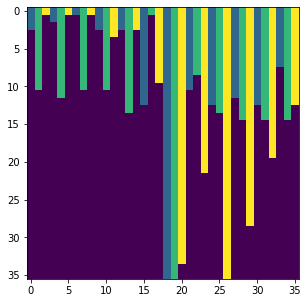

1.0 100


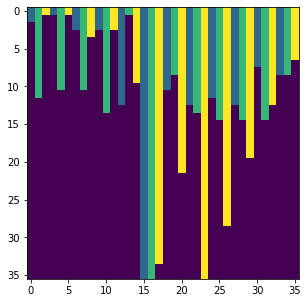

1.0 101


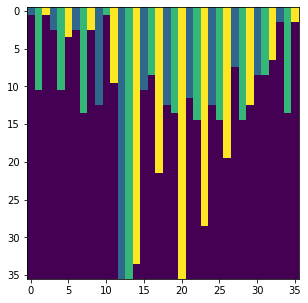

1.0 102


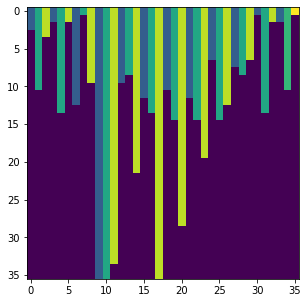

1.0 103


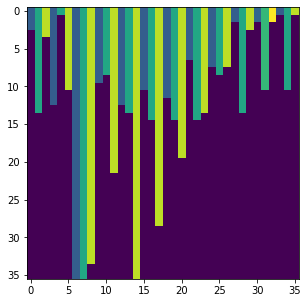

1.0 104


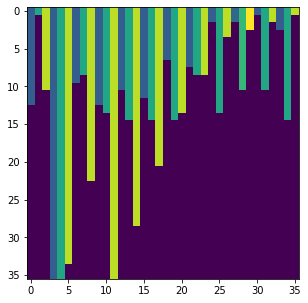

1.0 105


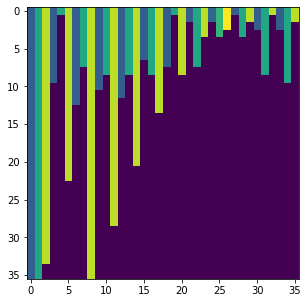

1.0 106


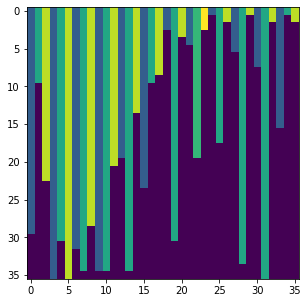

1.0 107


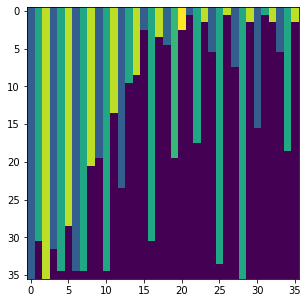

1.0 108


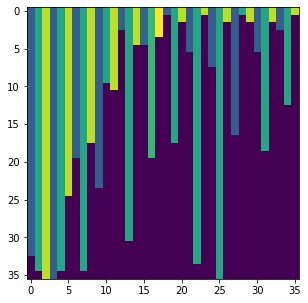

0.0 109


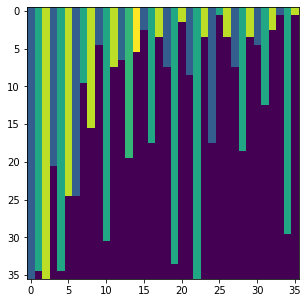

1.0 110


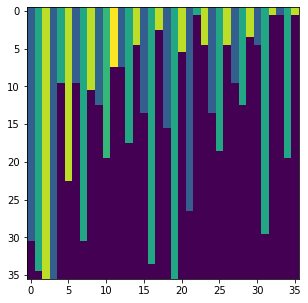

1.0 111


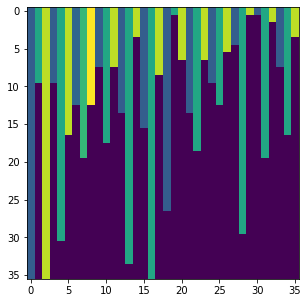

1.0 112


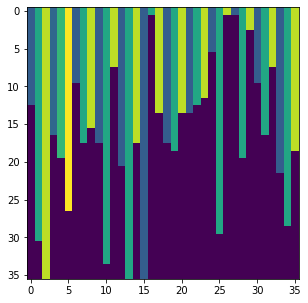

1.0 113


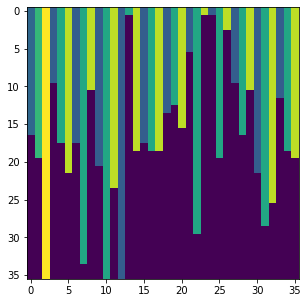

1.0 114


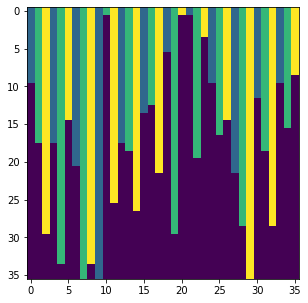

1.0 115


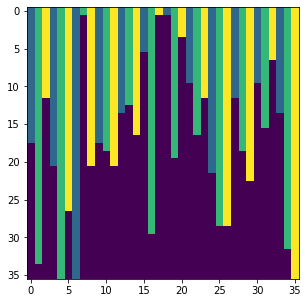

1.0 116


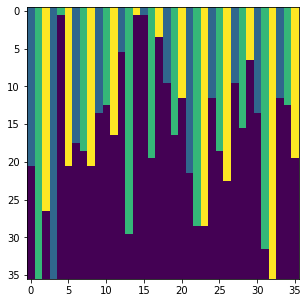

0.0 117


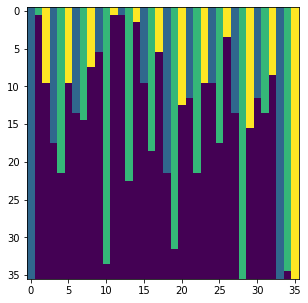

1.0 118


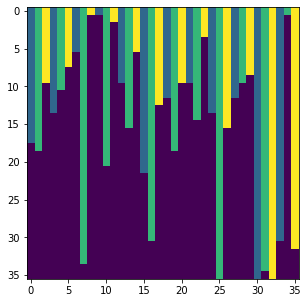

0.0 119


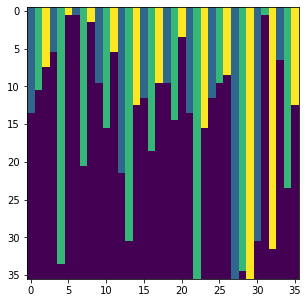

1.0 120


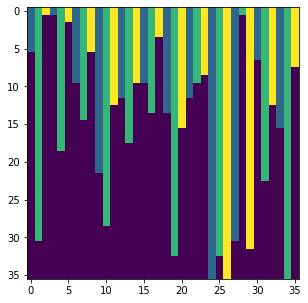

0.0 121


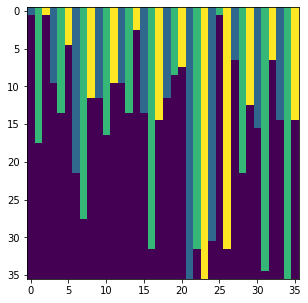

0.0 122


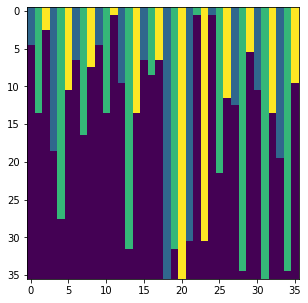

0.0 123


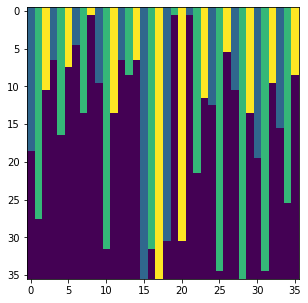

1.0 124


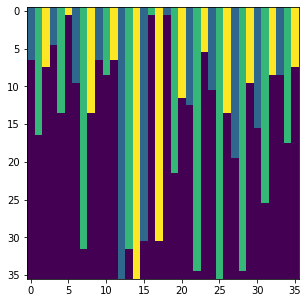

1.0 125


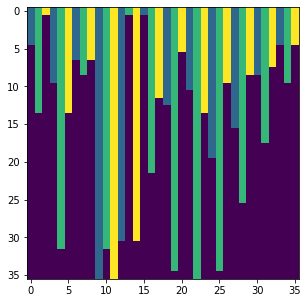

1.0 126


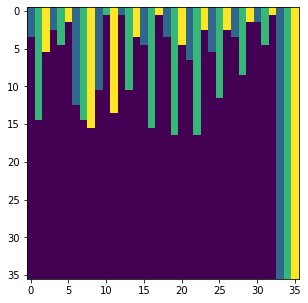

0.0 127


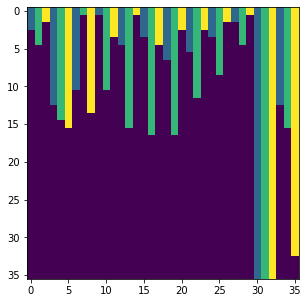

1.0 128


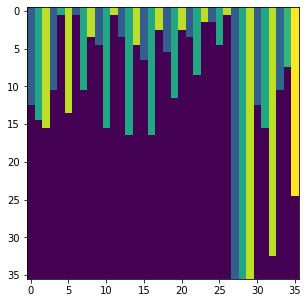

1.0 129


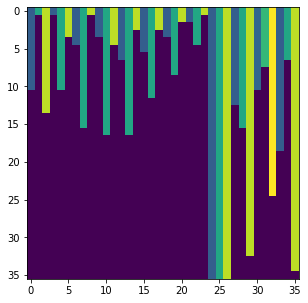

0.0 130


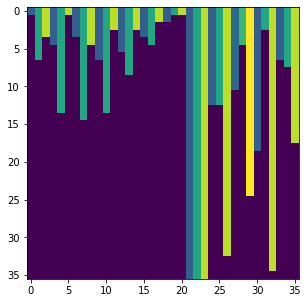

0.0 131


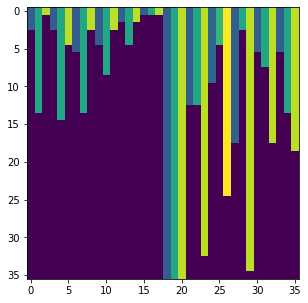

0.0 132


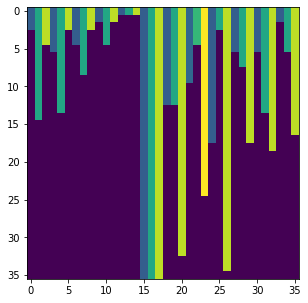

0.0 133


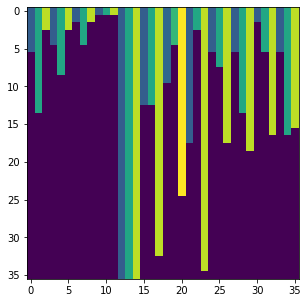

0.0 134


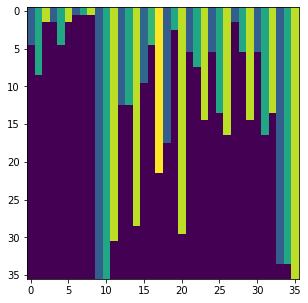

0.0 135


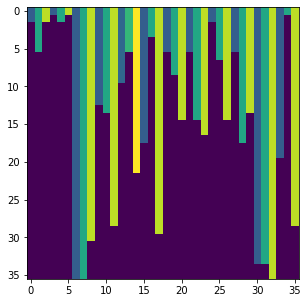

0.0 136


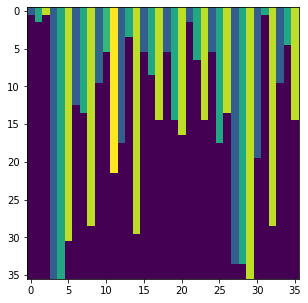

0.0 137


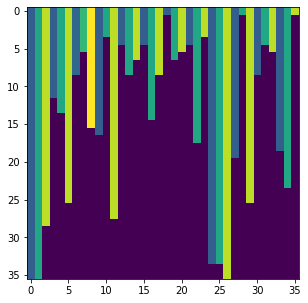

1.0 138


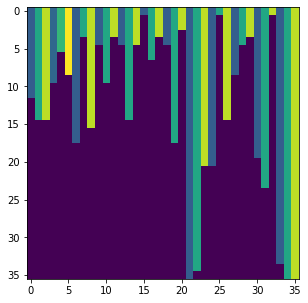

0.0 139


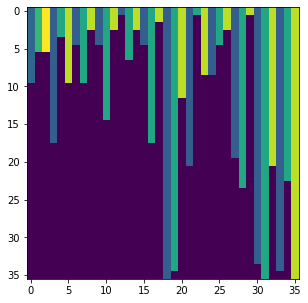

0.0 140


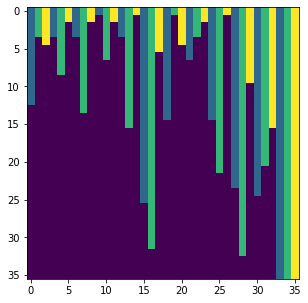

0.0 141


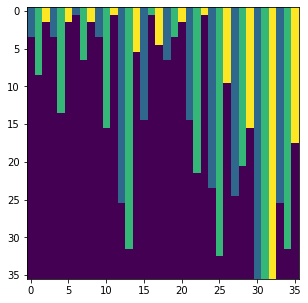

0.0 142


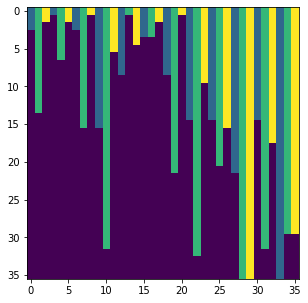

0.0 143


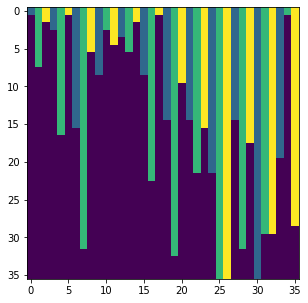

0.0 144


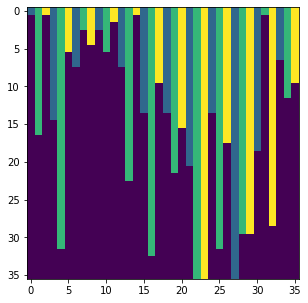

0.0 145


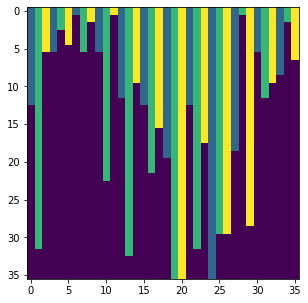

0.0 146


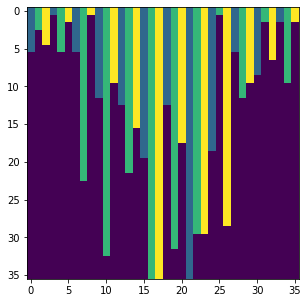

0.0 147


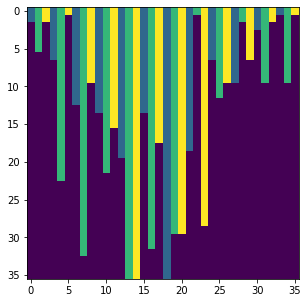

0.0 148


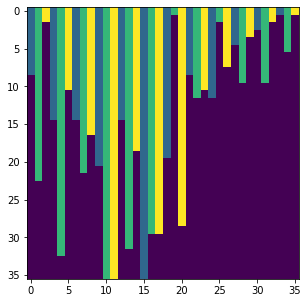

1.0 149


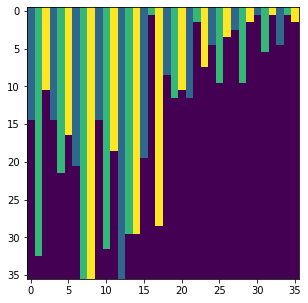

1.0 150


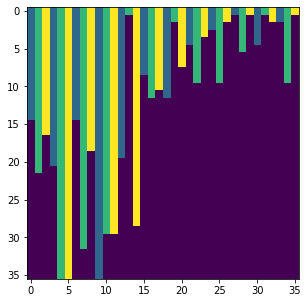

0.0 151


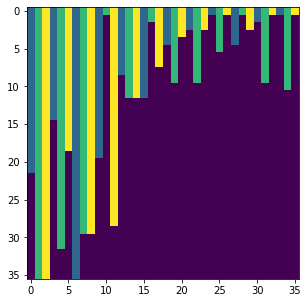

0.0 152


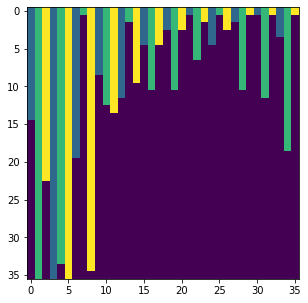

1.0 153


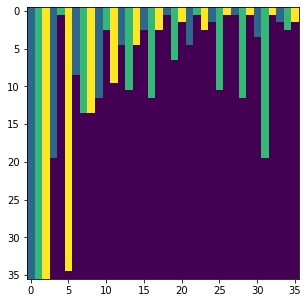

0.0 154


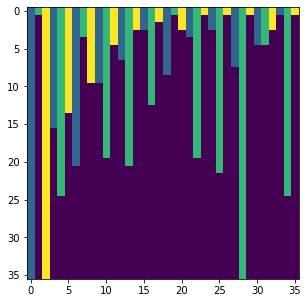

1.0 155


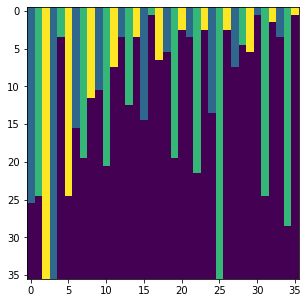

1.0 156


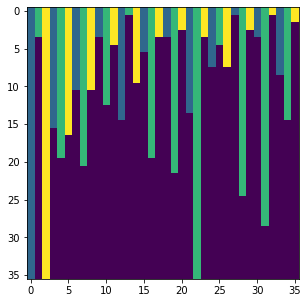

1.0 157


In [ ]:
image_size = 36
start_index = 12
for i in range(100,len(df)):
    box = np.zeros((image_size,image_size))

    data = df.loc[i-(start_index-1):i , ['High_low' , 'Open_close' , 'Volume']].values
    scaler = MinMaxScaler((1,image_size))
    data = scaler.fit_transform(data)
    hl = data[: , 0]
    oc = data[: , 1]
    v = data[: , 2]

    dm9 = df.loc[i-(start_index-1):i , 'Demark9'].values



    for ii in range(hl.shape[0]):
      bar_i = 3*ii
      for ii2 in range(round(hl[ii])):
        box[ii2][bar_i] = 1 * (dm9[ii] + 9)

      bar_i = (3*ii) +1
      for ii2 in range(round(oc[ii])):
        box[ii2][bar_i] = 2 * (dm9[ii] + 9)

      bar_i = (3*ii) +2
      for ii2 in range(round(v[ii])):
        box[ii2][bar_i] = 3 * (dm9[ii] + 9)
      
  # box1 = box

  # box = np.zeros((36,36))
  # data = df.loc[i-17:i , ['Volume']]
  # scaler = MinMaxScaler((1,36))
  # data = scaler.fit_transform(data)
  

  
  # hour = np.full((36,36) , df['Hour'][i])


  # box = np.dstack((box1,box))
  # box = np.dstack((box,hour))


    plt.imshow(box)
    plt.show()
    print(df['signals'].iloc[i] , i)

#**Model**

In [ ]:
from stable_baselines3 import A2C , DQN , PPO

In [ ]:
env = ForexEnv(df=df,frame_bound=(start_index + 1,int(df.shape[0]*0.8)) , capital=100 , leverage=50  , order_volume=1)

In [ ]:
model = DQN('CnnPolicy', env, verbose=1 ,  exploration_fraction=0.3)
# model = A2C('CnnPolicy', env, verbose=1)
model.learn(total_timesteps=int(250000))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
100 0 0 0
100 3926 52 0.5066225165562914
100 3926 96 0.5122261844116148
100 3926 -20 0.4974528782475802
100 3926 -74 0.4905756495160469
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93e+03 |
|    ep_rew_mean      | 13.5     |
|    exploration rate | 0.801    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5111     |
|    time_elapsed     | 3        |
|    total timesteps  | 15704    |
----------------------------------
100 3926 -42 0.49465104431991846
100 3926 -24 0.49694345389709627
100 3926 0 0.5
100 3926 -64 0.49184921039225676
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.93e+03 |
|    ep_rew_mean      | -9.5     |
|    exploration rate | 0.602    |
| time/               |          |
|    episodes      

In [ ]:
model.save("DQN_FOREX")

In [ ]:
del model

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# model = A2C.load("A2C_FOREX")
model = DQN.load("DQN_FOREX")

In [ ]:
from random import randint

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [ ]:
env = ForexEnv(df=df, frame_bound=(int(df.shape[0] * 0.9) ,df.shape[0]) , capital=100 , leverage=50  , order_volume=1)
obs = env.reset()
i = int(df.shape[0] * 0.9)
while True:
    obs = obs[np.newaxis, ...]

    action , _ = model.predict(obs)
    action = action[0]
    # action = df['signals'][i]

    # clear_output(wait=True)
    # plt.plot(df['Close'][i-30:i])
    # plt.show()

    if action == 0:
      print('buy')
    elif action == 1:
      print('sell')

    obs, rewards, done, info = env.step(action)
    i += 1
    if done:
        print(info)
        break

100 0 0 0
buy
buy
buy
buy
sell
buy
sell
buy
sell
buy
buy
buy
sell
sell
sell
buy
buy
buy
sell
sell
buy
buy
sell
buy
sell
sell
buy
sell
buy
sell
buy
sell
buy
sell
buy
sell
buy
sell
sell
sell
buy
buy
buy
sell
sell
sell
sell
sell
buy
buy
buy
buy
sell
sell
buy
sell
buy
buy
buy
buy
buy
buy
buy
sell
sell
buy
sell
sell
sell
sell
sell
buy
buy
buy
buy
buy
sell
buy
sell
sell
buy
sell
sell
buy
sell
sell
sell
sell
buy
buy
buy
sell
buy
buy
sell
buy
buy
buy
buy
sell
buy
sell
sell
buy
sell
buy
sell
sell
sell
sell
sell
buy
buy
sell
buy
sell
buy
sell
sell
sell
buy
sell
sell
buy
sell
sell
buy
buy
buy
sell
sell
buy
buy
sell
buy
sell
buy
buy
buy
sell
buy
buy
sell
sell
buy
sell
sell
sell
sell
sell
buy
sell
buy
buy
sell
buy
sell
sell
buy
sell
sell
sell
buy
buy
buy
buy
buy
buy
sell
sell
sell
buy
sell
buy
buy
buy
buy
buy
sell
buy
sell
sell
buy
sell
sell
sell
buy
sell
sell
sell
sell
buy
buy
buy
sell
sell
sell
buy
sell
buy
buy
buy
sell
buy
sell
buy
buy
buy
buy
sell
sell
buy
sell
sell
buy
sell
sell
sell
sell
buy


In [ ]:
env = ForexEnv(df=df, frame_bound=(13 ,df.shape[0]) , capital=100 , leverage=50  , order_volume=1)
obs = env.reset()
i = 13
while True: 
    obs = obs[np.newaxis, ...]
    
    action , _ = model.predict(obs)
    action = action[0]
    # action = df['signals'][i]
    print(action)
    obs, rewards, done, info = env.step(action)
    i += 1
    if done:
        print(info)
        break

100 0 0 0
1
1
0
1
0
1
1
0
0
0
1
1
0
0
1
1
0
1
0
0
0
0
1
0
1
1
0
0
1
0
1
0
0
0
1
1
1
1
0
1
0
1
0
0
1
1
1
1
0
0
0
0
1
1
0
1
1
1
0
0
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
1
1
1
1
0
1
1
0
1
0
1
1
1
1
1
0
0
0
0
1
1
0
0
0
1
1
0
0
0
1
0
1
0
1
0
1
1
1
1
0
1
0
1
1
1
0
0
1
0
0
0
0
1
0
0
0
0
1
0
1
1
1
0
0
1
1
0
1
0
0
1
0
0
0
1
1
0
0
0
1
0
0
1
0
1
0
0
1
1
0
0
0
0
1
1
0
1
0
0
1
0
0
0
1
0
0
1
0
0
1
0
0
0
0
1
1
1
0
0
0
1
1
0
1
0
1
0
0
1
1
0
1
1
0
0
1
0
1
1
1
0
1
0
0
0
0
0
1
0
1
0
1
0
0
1
1
1
1
0
0
0
0
0
1
0
0
0
0
0
0
1
1
0
1
1
1
1
1
1
0
0
1
1
1
1
0
1
1
1
0
1
1
0
0
0
1
1
1
0
1
1
1
1
0
1
0
1
0
0
1
0
0
1
0
0
1
0
1
0
0
0
0
0
1
1
1
0
1
1
1
1
0
1
1
1
1
1
0
0
0
0
1
0
1
0
0
1
0
1
0
0
0
1
1
0
0
0
0
0
0
1
1
0
0
1
1
0
0
0
0
1
0
0
1
1
0
0
1
1
0
0
0
1
1
0
0
0
1
1
0
1
1
0
1
0
1
1
0
0
1
1
1
0
1
0
1
0
1
1
1
0
1
1
1
0
0
1
0
1
1
0
0
1
1
0
1
0
1
1
0
1
0
0
0
1
1
1
0
1
1
0
0
1
0
1
0
0
1
0
1
1
1
1
1
0
0
0
0
0
0
1
1
1
1
1
0
1
0
0
1
0
1
1
0
1
0
1
1
0
1
0
1
0
1
1
0
0
1
0
0
0
1
0
0
1
0
1
1
1
1
1
1
0
0
1
0
0
0
1
0
1
0
1
0
1
1
1
1
1
0


In [ ]:
tp_target

0.68

In [ ]:
from google.colab import files
files.download('DQN_FOREX.zip') 

# **price visualization**

In [ ]:
import matplotlib.pyplot as plt

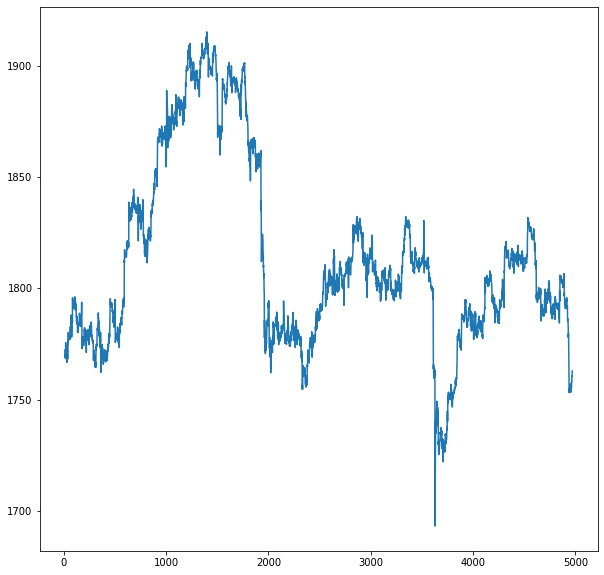

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(df.index, df['Close'])


#**Backtesting**

In [ ]:
from backtesting import Backtest, Strategy

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:47: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [ ]:
def signal_indicator():
  signal_features = []
  for i in range(30,len(df)):
      box = np.zeros((image_size,image_size))

      data = df.loc[i-(start_index-1):i , ['High_low' , 'Open_close' , 'Volume']].values
      scaler = MinMaxScaler((1,image_size))
      data = scaler.fit_transform(data)
      hl = data[: , 0]
      oc = data[: , 1]
      v = data[: , 2]

      dm9 = df.loc[i-(start_index-1):i , 'Demark9'].values

      for ii in range(hl.shape[0]):
        bar_i = 3*ii
        for ii2 in range(round(hl[ii])):
          box[ii2][bar_i] = 1 * (dm9[ii] + 9)

        bar_i = (3*ii) +1
        for ii2 in range(round(oc[ii])):
          box[ii2][bar_i] = 2 * (dm9[ii] + 9)

        bar_i = (3*ii) +2
        for ii2 in range(round(v[ii])):
          box[ii2][bar_i] = 3 * (dm9[ii] + 9)

      signal_features.append(box)
    
  signals = []
  for obs in signal_features:
    obs = obs[np.newaxis, ...]
    signal , _ = model.predict(obs)

    signals.append(signal)

  return signals

In [ ]:
def signal_indicator():
  return df['signals']

In [ ]:
class ghodrat(Strategy):
    def init(self):
      price = self.data.Close
      self.signal = self.I(signal_indicator)

    def next(self):
      if self.signal == 0:
          self.buy(tp=self.data.Close[-1] + tp_target , sl=self.data.Close[-1] - (tp_target/2))
      elif self.signal == 1:
          self.sell(tp=self.data.Close - tp_target , sl=self.data.Close + (tp_target/2))

bt = Backtest(df.iloc[:], ghodrat, commission=.0,
              exclusive_orders=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  del sys.path[0]


In [ ]:
stats = bt.run()
bt.plot()

ValueError: ignored